### Notebook that reads the output of STability Change of subtrates from CCLE dataset and visualize the volcano plot

### Read data 

In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

### paths

In [2]:
base="../../" 
# output drivers TCGA
path_drivers_ccle= os.path.join(base,"data","signals_E3_ligases_ccle.tsv")
# output
path_output_analysis= os.path.join(base,"data","output_e3_ligases_change_stability")
path_colors = os.path.join(base,"degrons",'positive_selection','analysis',"dict_colors.json")
# run tcga
run="tcga"
# interacting pairs
output_pickle_annotated = os.path.join(base,'data', 'dict_annotated_pairs.json' )
output_pickle_all = os.path.join(base,'data', 'dict_all_pairs.json' )
# Plots 
path_output_plots = os.path.join(base,"plots","Figure6")


### Load interacting pairs

In [3]:
dict_annotated = json.load(open(output_pickle_annotated,'r'))
dict_all = json.load(open(output_pickle_all,'r'))

### Load drivers

In [4]:
df_drivers_ccle = pd.read_csv(path_drivers_ccle,sep="\t")
d_drivers = {}
for hugo,cancer in df_drivers_ccle[(df_drivers_ccle["oncodrivefml_qvalue"]<0.1)|(df_drivers_ccle["dndscv_qvalue"]<0.1)][["Hugo_Symbol","Cancer_Type"]].drop_duplicates().values:
    if hugo in d_drivers:
        d_drivers[hugo]=d_drivers[hugo].union(set([cancer]))
    else:
        d_drivers[hugo]=set([cancer])

### aux functions

In [5]:
def check_evidence(row):
    # Get whether is annotated or predicted link
    e3 = row["Protein_Driver_Mutated"]
    sub = row["Hugo_Symbol"]
    if e3 in dict_annotated:
        if sub in dict_annotated[e3]:
            return "Annotated"
        return "Predicted"
    return "Predicted"
def check_driver(row):
    # Get whether is annotated or predicted link
    e3 = row["Protein_Driver_Mutated"]
    ttype = row["Cancer_Type"]
    if e3 in d_drivers:
        if ttype in d_drivers[e3]:
            return "Driver"
        return "No-Driver"
    return "No-Driver"
def get_fc(row):
    # Get magnitude of change
    if row["Type_Change"] == "increase":
        return np.abs(row["Mean_MT"] - row["Mean_WT"])
    else:
        return -(row["Mean_WT"] -row["Mean_MT"])
    return val
def set_color(row,colors):
    if row["Cancer_Type"] in colors:
        return colors[row["Cancer_Type"]]
    else:
        return "black"


### Iterate over the outputs and read them

In [6]:
l = []
for filef in glob.glob(path_output_analysis+"/*"+"_CCLE.tsv.gz"):
    df = pd.read_csv(filef,sep="\t")
    if df.shape[0] >0:
        df["Evidence"] = df.apply(lambda row: check_evidence(row),axis=1)
        df["Driver"] = df.apply(lambda row: check_driver(row),axis=1)
        l.append(df)
df_total = pd.concat(l)

In [8]:
filef

'/workspace/projects/ubiquitins/codereview/degradation/data/output_e3_ligases_change_stability/PAN_CCLE.tsv.gz'

### Prepare visualization

##### Load colors

In [7]:
dict_colors = json.load(open(path_colors,'r'))

In [8]:
df_total["log_qvalue"] = -np.log10(df_total["Q_value"])
df_total["color"] = df_total.apply(lambda row:set_color(row,dict_colors),axis=1)
df_total["effect_size"] = df_total.apply(lambda row:get_fc(row),axis=1)
df_total["significant"] = df_total.apply(lambda row:True if row["Q_value"]<0.1 and row["Type_Change"] == "increase" else False,axis=1)
df_total["text"] = df_total.apply(lambda row:row["Protein_Driver_Mutated"]+"-"+row["Hugo_Symbol"]+row["Protein"].split("_")[1] if "_p" in row["Protein"] else row["Protein_Driver_Mutated"]+"-"+row["Hugo_Symbol"] ,axis=1)
#df_total["lw"] = df_total.apply(lambda row: 0.3 if row["Evidence"]=="Annotated" else 0.0,axis=1)
df_total["lw"] = df_total.apply(lambda row: 0.3 if row["Driver"]=="Driver" else 0.0,axis=1)
df_total["ec"] = df_total.apply(lambda row: "black" if row["Driver"]=="Driver" else row["color"],axis=1)

### Matplotlib

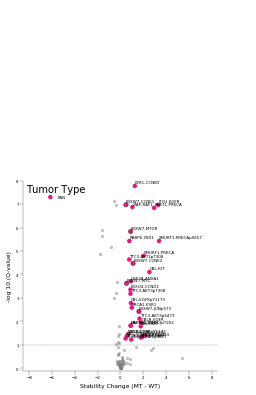

In [9]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
df_sigs = df_total[(df_total["significant"])]
df_not_sigs = df_total[~(df_total["significant"])]
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=20,linewidths=df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values,label=cancer_type,marker="o",edgecolors=df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ec"].values)
    for i in range(len(xs)):
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass
# create the coordinates for the errorbars

ax.set_ylabel("-log 10 (Q-value)",fontsize=6)
ax.set_xlabel("Stability Change (MT - WT)",fontsize=6)
marker_size = 20
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.25, title='Tumor Type',markerscale=1,loc="upper left",fontsize=4)
ax.scatter(x=df_not_sigs["effect_size"].values,y=df_not_sigs["log_qvalue"].values,color="grey",s=10,alpha=0.5,linewidths=0)

#x=ax.legend()
ylim=(-0.1,8)
ax.set_ylim(ylim)
# Adjust axis
maxv = np.nanmax(df_total["effect_size"].values)+0.1
xlim=(-maxv,maxv)
ax.set_xlim(xlim)
ax.axhline(y=-np.log10(0.1),xmin=0,xmax=maxv,color="black",ls="--",lw=0.2)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
plt.savefig(path_output_plots+'/E3_substrate_changes_CCLE.pdf', dpi=100,bbox_inches="tight")
plt.show()
None


### No limit!

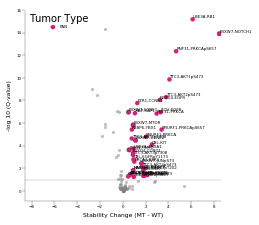

In [10]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
df_sigs = df_total[(df_total["significant"])]
df_not_sigs = df_total[~(df_total["significant"])]
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=20,linewidths=df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values,label=cancer_type,marker="o",edgecolors=df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ec"].values)
    for i in range(len(xs)):
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass
# create the coordinates for the errorbars

ax.set_ylabel("-log 10 (Q-value)",fontsize=6)
ax.set_xlabel("Stability Change (MT - WT)",fontsize=6)
marker_size = 20
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.25, title='Tumor Type',markerscale=1,loc="upper left",fontsize=4)
ax.scatter(x=df_not_sigs["effect_size"].values,y=df_not_sigs["log_qvalue"].values,color="grey",s=10,alpha=0.5,linewidths=0)

#x=ax.legend()
ylim=(-0.1,6)
#ax.set_ylim(ylim)
# Adjust axis
maxv = np.nanmax(df_total["effect_size"].values)+0.1
xlim=(-maxv,maxv)
ax.set_xlim(xlim)
ax.axhline(y=-np.log10(0.1),xmin=0,xmax=maxv,color="black",ls="--",lw=0.2)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
plt.savefig(path_output_plots+'/E3_substrate_changes_CCLE_nolimit.pdf', dpi=100,bbox_inches="tight")
plt.show()
None


In [19]:
df_sigs[df_sigs["Hugo_Symbol"]=="RB1"]

Protein_Driver_Mutated Cancer_Type        Protein Hugo_Symbol  \
103                  UBE3A         PAN  Rb_pS807_S811         RB1   
104                  UBE3A         PAN     Rb_Caution         RB1   

          P_value Type_Change   Mean_MT   Mean_WT  Len_MT  Len_WT  \
103  2.776614e-02    increase  1.599857  0.640681      27      35   
104  5.842695e-18    increase  6.261180  0.139067      27     653   

          Q_value   Evidence     Driver  log_qvalue    color  effect_size  \
103  5.867561e-02  Annotated  No-Driver    1.231542  #dd1c77     0.959176   
104  6.543818e-16  Annotated  No-Driver   15.184169  #dd1c77     6.122112   

     significant            text   lw       ec  
103         True  UBE3A-RB1pS807  0.0  #dd1c77  
104         True       UBE3A-RB1  0.0  #dd1c77